### Homework - Neural Network from Scratch
  
参考文献:  
https://github.com/pangolulu/neural-network-from-scratch  

<b>全体処理フロー:</b>  
1. インポート
2. 計算グラフの構築  
3. モデルの構築  
4. 学習の実行と可視化

##### <font color = "Indigo"><b>1. インポート</b></font>　

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

##### <font color = "Indigo"><b>2. 計算グラフの構築</b></font>　　

In [2]:
# 1) Gate
class MultiplyGate:
    def forward(self, W, X):
        return np.dot(X, W)
    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)  # transpose関数について↓
        dX = np.dot(dZ, np.transpose(W))  # https://www.coursera.org/learn/neural-networks-deep-learning/lecture/87MUx/a-note-on-python-numpy-vectors
        return dW, dX

class AddGate():
    def forward(self, X, b):
        return X + b
    
    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)  # numpy.ones_like: 受け取る配列の要素の値を「1」に設定
        db = np.dot(np.ones((1, dZ.shape[0]), dtype = np.float64), dZ)  # numpy.ones: 要素が「1」の配列を新規に作成
        return db, dX

# 2) Layer
class Tanh:
    def forward(self, X):
        # return np.tanh(X)  # もしくは↓ (結果は同じ)
        molecule =    np.exp(X) - np.exp(-X)
        denominator = np.exp(X) + np.exp(-X)
        return molecule / denominator
    
    def backward(self, X, top_diff):
        output = self.forward(X)  #? なぜbackwardでforward
        return (1.0 - np.square(output)) * top_diff

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

# 3) Output
# softmax関数: 出力の各成分が0以上1以下で成分の和が1となる
# 指数: べき乗した算出値 (8 = 2^3     <- 2を3乗すると「8」になる)
# numpy.exp(): ネイピア数を底とする指数関数 (numpy.exp(2) = 7.3890...)
# 対数: べき乗する値    (3 = log2(8) <- 2を8にするには「3」乗する)
# numpy.log(): ネイピア数を底とする対数関数 (numpy.log(2) = 0.6931...)
class Softmax:
    # Predict: 「ネイピア数を入力値でべき乗した合計」で「ネイピア数の入力値のべき乗」で割る
    def predict(self, X):
        exp_scores = np.exp(X)
        # numpy.sumのkeepdims: 入力の次元と出力の次元を合わせるかどうかbool値で指定
        return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        # 予測値とラベルの差をマイナスの対数で出力
        correct_logprobs = -np.log(probs[range(num_examples), y])
        # 誤差を全て足す
        data_loss = np.sum(correct_logprobs)
        # 入力値に誤差の合計を足したものを掛けて1で割る
        return 1.0 / num_examples * data_loss
    
    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        # 予測値とラベルの差を1で引いて1からの隔たりを出力
        probs[range(num_examples), y] -= 1
        return probs

##### <font color = "Indigo">3. モデルの構築<b></b></font>  

In [3]:
class Model:
    def __init__(self, layers_dim):  # コンストラクタの定義
        self.W = []
        self.b = []
        for i in range(len(layers_dim) - 1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i + 1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i + 1]).reshape(1, layers_dim[i + 1]))
    
    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        # layer = Sigmoid()
        softmaxOutput = Softmax()
        
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
        
        return softmaxOutput.loss(input, y)
    
    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        # layer = Sigmoid()
        softmaxOutput = Softmax()
        
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
        
        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis = 1)
    
    def train(self, X, y, num_passes = 20000, epsilon = 0.01, reg_lambda = 0.01, print_loss = False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        # layer = Sigmoid()
        softmaxOutput = Softmax()
        
        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))
            
            # 誤差逆伝播 - 1.活性化、2.線形結合( + バイアス)、3.線型結合(出力 x 重み)の順
            dtanh = softmaxOutput.diff(forward[len(forward) - 1][2], y)
            for i in range(len(forward) - 1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i - 1], dadd)
                dW, dtanh = mulGate.backward(self.W[i - 1], forward[i - 1][2], dmul)
                # Regularization
                dW += reg_lambda * self.W[i - 1]
                # 勾配パラメータの計算
                self.b[i - 1] += -epsilon * db
                self.W[i - 1] += -epsilon * dW
            
            if print_loss and epoch % 1000 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

<font color = "Indigo"><b>4. 学習の実行と可視化</b></font>

<b>学習処理フロー:</b>  
1. 学習 - model.train  
1) フォーワード処理  
　・線型結合(入力値 x 重み) - Multiply.forward  
　・線型結合( + バイアス) - Add.forward  
　・活性化 - Tanh.forward  
2) 出力誤差の計算 - Softmax.diff  
3) 誤差逆伝播  
　・活性化 - Tanh.backward  
　・線型結合( + バイアス) - Add.backward  
　・線形結合(入力値 x 重み) - Multiply.backward  
　・勾配パラメータ(バイアスと重み)更新 - 0.01 x db -> 0.01 x dW  
2. 予測 - model.predict  
1) フォーワード処理  
　・線型結合(入力値 x 重み) - Multiply.forward  
　・線型結合( + バイアス) - Add.forward   
2) 予測の出力 - Softmax.predict 

In [4]:
def plot_decision_boundary(pred_func, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

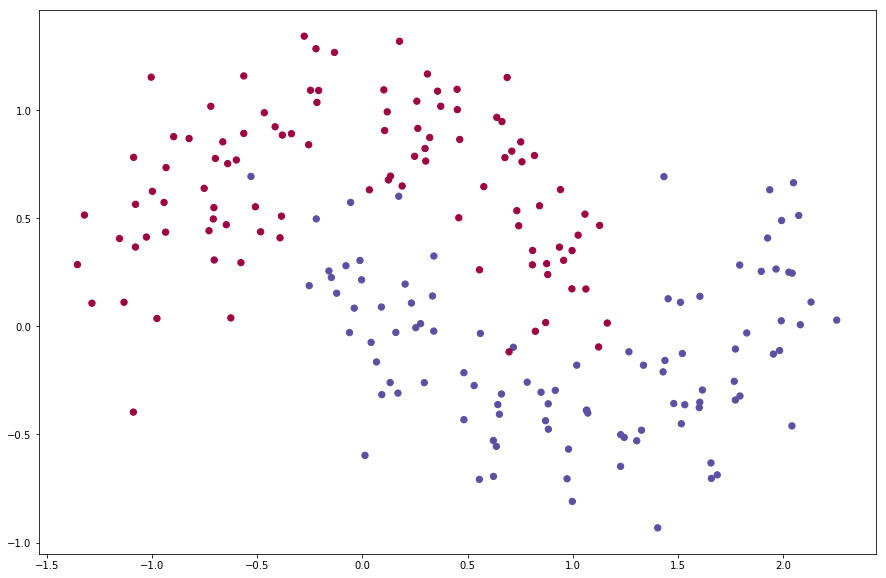

Loss after iteration 0: 0.700172
Loss after iteration 1000: 0.322803
Loss after iteration 2000: 0.193222
Loss after iteration 3000: 0.163436
Loss after iteration 4000: 0.161711
Loss after iteration 5000: 0.160970
Loss after iteration 6000: 0.160583
Loss after iteration 7000: 0.160362
Loss after iteration 8000: 0.160229
Loss after iteration 9000: 0.160147
Loss after iteration 10000: 0.160094
Loss after iteration 11000: 0.160060
Loss after iteration 12000: 0.160037
Loss after iteration 13000: 0.160022
Loss after iteration 14000: 0.160012
Loss after iteration 15000: 0.160005
Loss after iteration 16000: 0.160001
Loss after iteration 17000: 0.159997
Loss after iteration 18000: 0.159995
Loss after iteration 19000: 0.159994


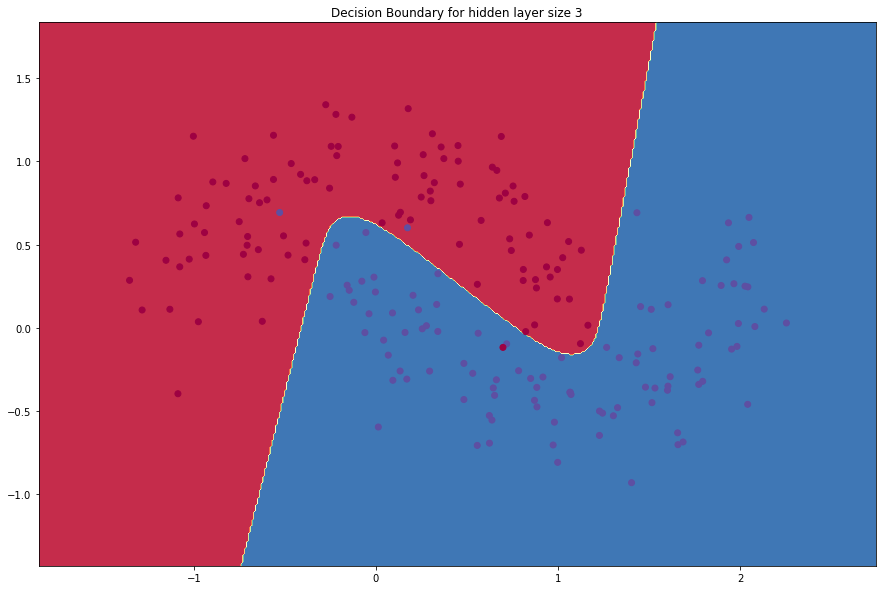

In [5]:
# Generate dataset
np.random.seed(0)  # 乱数を固定
X, y = datasets.make_moons(200, noise = 0.20)
plt.figure(figsize = (15, 10))
plt.scatter(X[:, 0], X[:, 1], s = 40, c = y, cmap = plt.cm.Spectral)
plt.show()
# 入力=2 / 隠れ層=3 / 出力=2
layers_dim = [2, 3, 2]
# 予測の実行
model = Model(layers_dim)
model.train(X, y, num_passes = 20000, epsilon = 0.01, reg_lambda = 0.01, print_loss = True)

plt.figure(figsize = (15, 10))
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()